# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Correlations with survey

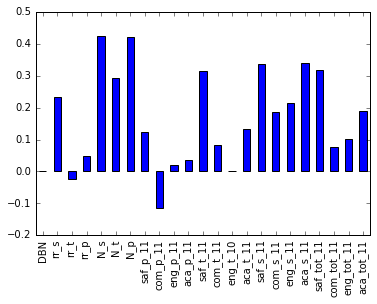

In [10]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with  sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring safety

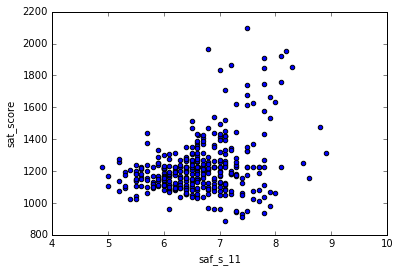

In [11]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

# Density Estimation of the Safety

Lets see the most frequent score of the safety by students survey

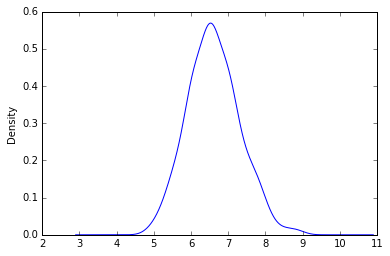

In [12]:
combined["saf_s_11"].plot(kind="kde")

The most density of Safety score between 6 and 7

Let's see the density estimation of the safety by school where number of male is greater than number of female (blue line) and otherwise (red line).

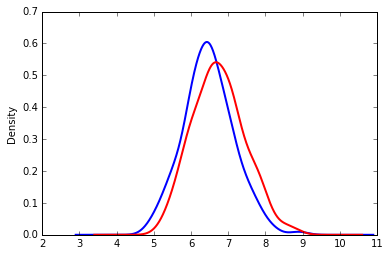

In [13]:
combined["saf_s_11"][combined['male_num'] > combined['female_num']].plot(kind="kde", linewidth=2, style='blue')
combined["saf_s_11"][combined['male_num'] < combined['female_num']].plot(kind="kde", linewidth=2, style='red')

It is no point to get density by school with equal count of male and female students, because there are only two school in this case with different safety score.

In [14]:
combined.loc[:,['SCHOOL NAME',"saf_s_11"]][combined['male_num'] == combined['female_num']]

,SCHOOL NAME,saf_s_11
166,NEW WORLD HIGH SCHOOL,7.1
357,ACADEMY FOR ENVIRONMENTAL LEADERSHIP,5.8


# Plotting safety

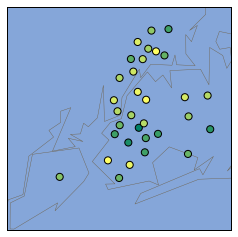

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Racial at SAT scores

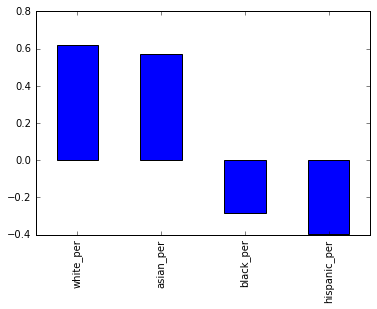

In [16]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. 

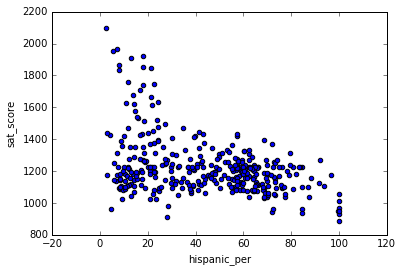

In [17]:
combined.plot.scatter("hispanic_per", "sat_score")

Looks like high sat score (more than 1600) have schools with few number of hispanic students (fewer than 30%). Most schools with part of hispanic students greater than 30% have sat score fewer than 1500

# Schools with a greater than 95% hispanic_per

In [18]:
combined.loc[:,['SCHOOL NAME', "hispanic_per"]][(combined["hispanic_per"] >= 95)].sort_values(by="hispanic_per", ascending=False)

,SCHOOL NAME,hispanic_per
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7


By the http://wikipedia.org the "PAN AMERICAN INTERNATIONAL HIGH SCHOOL" is a part of 
Internationals Network for Public Schools. 
The Internationals Network for Public Schools is an educational nonprofit
supporting International high schools and academies, serving newly arrived immigrants who are English language learners (ELLs), in New York, California, Kentucky, Maryland, Virginia, and Washington, DC. Internationals Network also partners with other schools and districts across the country. 

"WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL" by the http://wheelsnyc.org WHEELS opened in the fall of 2006 in the Washington Heights section of Manhattan, as a new school in Community School District (CSD) 6, the most over-crowded school district in New York City. 

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

# Schools with a less than 10% hispanic_per, and greater than 1800 average SAT score

In [19]:
combined.loc[:,["SCHOOL NAME", "sat_score"]][(combined["hispanic_per"] <= 10) & (combined["sat_score"] >= 1800)]

,SCHOOL NAME,sat_score
37,STUYVESANT HIGH SCHOOL,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0


Following information by http://wikipedia.org

Top sat score school is 
#### Stuyvesant High School 
is one of nine specialized high schools in New York City, United States. Operated by the New York City Department of Education, these schools offer tuition-free accelerated academics to city residents. Stuyvesant is a college preparatory science, technology, engineering, and mathematics (STEM) focused liberal arts high school.

Admission to Stuyvesant involves passing the Specialized High Schools Admissions Test.

Second sat score place is
#### Bronx High School of Science 
(commonly called Bronx Science or Science, and formerly Science High) is a selective public high school in New York City. It is one of nine "specialized" public high schools located in New York City and operated by the New York City Department of Education. 

Third sat score place is 
#### Brooklyn Technical High School
commonly referred to as Brooklyn Tech, and administratively designated as High School 430, is a New York City public high school that specializes in science, technology, engineering, and mathematics. It is one of three original specialized high schools operated by the New York City Department of Education, the other two being Stuyvesant High School and Bronx High School of Science. 

So top 3 sat score schools are operated by New York city Department of  Education. 
"Admission to Stuyvesant involves passing the Specialized High Schools Admissions Test" it can be some explanation of the highest sat score of the school.

# Gender And SAT Scores

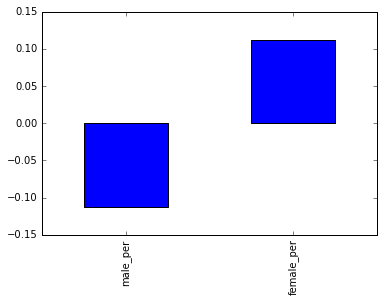

In [20]:
combined.corr()["sat_score"][["male_per", "female_per"]].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

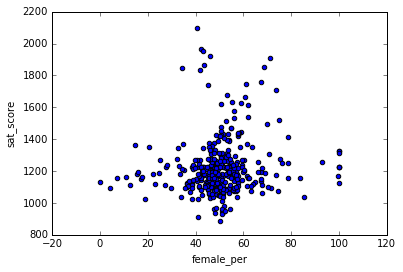

In [21]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

#### Schools with a greater than 60% female_per, and greater than 1700 average SAT score

In [22]:
combined.loc[:,("SCHOOL NAME", "sat_score")][(combined["female_per"] >= 60) & (combined["sat_score"] >= 1700)].sort_values(by="sat_score", ascending=False)

,SCHOOL NAME,sat_score
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0
60,BEACON HIGH SCHOOL,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0


These schools appears to be very selective liberal arts schools that have high academic standards.

Some schools info
Following information by http://wikipedia.org
#### Townsend Harris High School 
is a public magnet high school for the humanities in the borough of Queens in New York City. Students and alumni often refer to themselves as "Harrisites." Townsend Harris **consistently ranks as among the top 100 High Schools** in the United States.
#### Bard High School Early College (BHSEC) 
is an alternative public secondary school in New York City, United States, that **allows highly motivated and scholastically strong students to begin their college studies two years early**. Students complete their high school requirements in two years and then embark on college work. After four years, they receive both a Regents diploma and an associate degree. 
#### Eleanor Roosevelt High Schoo 
is a small public high school on the Upper East Side of Manhattan in New York City. Eleanor Roosevelt High School is composed of about 33 teachers and 500 students representing over 40 different countries. Initially opened at a temporary location in Chelsea, with 105 ninth graders and a staff of eight, ERHS currently has over 500 students and over 45 staff members. Every year, **the school selects 125 to 140 students out of over 6,000 applicants** and is often selected over specialized high schools by students looking for a more liberal curriculum. In 2015, Eleanor Roosevelt High School was ranked the 116th best public high school in the nation by U.S. News & World Report.
#### The Beacon School 
is a selective college-preparatory public high school in the Hell's Kitchen area of Manhattan in New York City, near Times Square and the Theater District. **Beacon's curriculum exceeds the standards set by the New York State Regents**, and as a member of the New York Performance Standards Consortium, its students are exempt from taking most Regents exams. Instead, students present performance-based projects at the end of each semester to panels of teachers. Beacon offers extensive opportunities to participate in student organizations, varsity athletics, community service, and international travel.
#### Fiorello H. LaGuardia High School of Music & Art and Performing Arts 
is a high school specializing in teaching visual arts and performing arts, situated near Lincoln Center in the Lincoln Square neighborhood of the Upper West Side, Manhattan, New York City, in the U.S. state of New York. Located at 108 Amsterdam Avenue between West 64th and 65th Streets, the school is operated by the New York City Department of Education, and resulted from the merger of the High School of Music & Art and the School of Performing Arts. The school has a dual mission of arts and academics, preparing students for a career in the arts or conservatory study as well as a pursuit of higher education.

Informally known as LaGuardia Arts, or LaGuardia High School, the school is the only one among the nine specialized high schools in New York City that **receives special funding** from the New York State legislature through the Hecht Calandra Act.[citation needed]

##### Top 5 of schools with greater than 1700 SAT score and greater than 60% of female:
* are in top 100 USA schools 
* ranks as among the top 100 High Schools 
* selects 125 to 140 students out of over 6,000 applicants
* curriculum exceeds the standards set by the New York State Regents
* receives special funding

# AP Scores Vs SAT Scores

Get percentage of students in each school that took AP exam

In [23]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"] * 100

Get relationship between AP scores and SAT scores

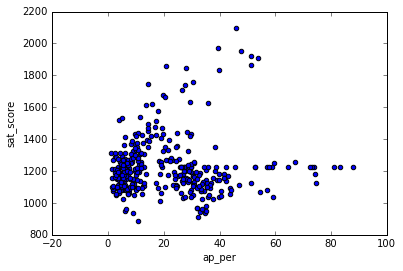

In [24]:
combined.plot.scatter("ap_per", "sat_score")

There is some relationship between the percentage of students in a school who take the AP exam, and their average SAT scores, but no strong correlation

# Class size and SAT scores

Lets try to find correlation between class size and SAT score. 

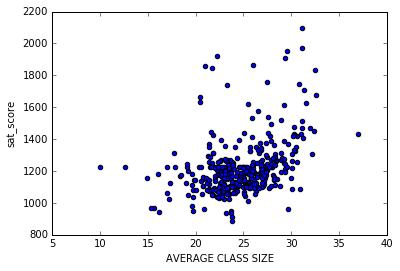

In [25]:
combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

It looks like there is no strong correlation between Average class size and SAT score.  
But high SAT scores (higher 1600) appears in classes with number of students from 20 to 35

Lets divide class sizes on some size groups to get correlation with SAT score.  
Make density plot from class sizes.  

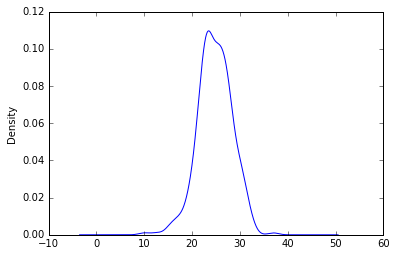

In [26]:
combined["AVERAGE CLASS SIZE"].plot(kind="kde")

As we can see,  
most of the classes has size between 20 and 30 students it is the one 'Major' group  
and group with number of studens below 20  
and group with number of studens higher 30  



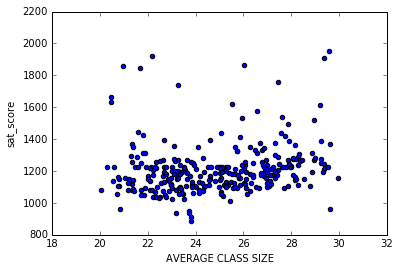

In [27]:
Major_group = combined[(combined["AVERAGE CLASS SIZE"] >= 20) & (combined["AVERAGE CLASS SIZE"] <= 30)]
Major_group.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

The 'Major' group has no correlation.  Obviously most students has 'SAT score' around 1200.  
Most students at 'Major' group has 'SAT score' equal:

In [28]:
Major_group["sat_score"].sum() / len(Major_group)

1209.5329821480832

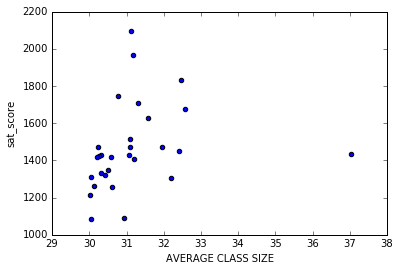

In [29]:
combined[(combined["AVERAGE CLASS SIZE"] > 30)].plot.scatter("AVERAGE CLASS SIZE", "sat_score")

The "over 30 students in class" group has no correlation.

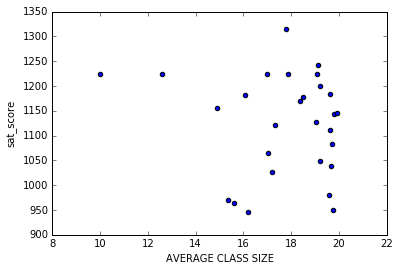

In [30]:
combined[(combined["AVERAGE CLASS SIZE"] < 20)].plot.scatter("AVERAGE CLASS SIZE", "sat_score")

The "below 20 students in class" group has no obviouse correlation.

In [31]:
combined.columns.values

array(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName',
       'AP Test Takers ', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5', 'Demographic',
       'School Name', 'Cohort', 'Total Cohort', 'Total Grads - n',
       'Total Grads - % of cohort', 'Total Regents - n',
       'Total Regents - % of cohort', 'Total Regents - % of grads',
       'Advanced Regents - n', 'Advanced Regents - % of cohort',
       'Advanced Regents - % of grads', 'Regents w/o Advanced - n',
       'Regents w/o Advanced - % of cohort',
       'Regents w/o Advanced - % of grads', 'Local - n',
       'Local - % of cohort', 'Local - % of grads', 'Still Enrolled - n',
       'Still Enrolled - % of cohort', 'Dropped Out - n',
       'Dropped Out - % of cohort', 'CSD',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALL